<a href="https://colab.research.google.com/github/rana7210/AlphaFold_Experiment/blob/main/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [3]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

In [4]:
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

In [5]:
# REPLACE the whole multi-line block with the colon-separated version (no headers)
query_sequence = (
  "MKSQQQAKEWIYKHEGTGVDFDGAYGFQCMDLAVAYVYYITDGKVRMWGNAKDAINNDFKGLATVYENTPSFKPQLGDVAVYTNSQYGHIQCVISGNLDYYTCLEQNWLGGGFDGWEKATIRTHYYDGVTHFIRPKFSASNSNVLETSKVNTFGNWKQNQYGTYYRNENATFTCGFLPIFARVGSPKLSEPNGYWFQPNGYTPYDEVCLSDGLVWIGYNWQGTRYYLPVRQWNGKTGNSYSIGLPWGVFS:MAKIKGQVKWFNESKGFGFITPADGSKDVFVHFSAIQGNGFKTLAEGQNVEFEIQDGQKGPAAVNVTAI"
)

In [6]:

#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'reference' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname FullandCspAagainaftercbd_3b649
sequence MKTYSEARARLRWYQGRYIDFDGWYGYQCADLAVDYIYWLLEIRMWGNAKDAINNDFKNMATVYENTPSFVPQIGDVAVFTKGIYKQYGHIGLVFNGGNTNQFLILEQNYDGNANTPAKLRWDNYYGCTHFIRPKYKSEGL:MTVLAQTTLPANADNGAFAALAAEQFGNGWSVVGNFGEAQEQQQSRQVVTFVHGKFIQLVDGRAKTVAVGKELGAAEVIKS
length 222


In [7]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 1.2 ms, sys: 1.62 ms, total: 2.82 ms
Wall time: 35.9 s


In [8]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [9]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "12" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = True #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 8 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = True #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 300 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

You are logged into Google Drive and are good to go!


2025-09-10 12:47:14,596 Running on GPU
2025-09-10 12:47:15,038 Found 5 citations for tools or databases
2025-09-10 12:47:15,038 Query 1/1: FullandCspAagainaftercbd_3b649 (length 222)


PENDING:   0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2025-09-10 12:47:15,333 Sleeping for 9s. Reason: PENDING


RUNNING:   3%|▎         | 9/300 [elapsed: 00:09 remaining: 05:08]

2025-09-10 12:47:24,598 Sleeping for 9s. Reason: RUNNING


RUNNING:   6%|▌         | 18/300 [elapsed: 00:18 remaining: 04:54]

2025-09-10 12:47:33,869 Sleeping for 7s. Reason: RUNNING


RUNNING:   8%|▊         | 25/300 [elapsed: 00:26 remaining: 04:46]

2025-09-10 12:47:41,131 Sleeping for 9s. Reason: RUNNING


RUNNING:  11%|█▏        | 34/300 [elapsed: 00:35 remaining: 04:35]

2025-09-10 12:47:50,408 Sleeping for 5s. Reason: RUNNING


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:41 remaining: 00:00]


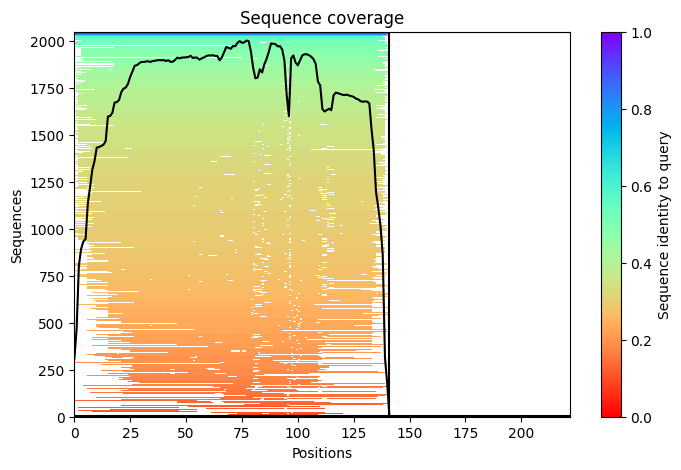

2025-09-10 12:47:57,635 Setting max_seq=508, max_extra_seq=1542
2025-09-10 12:49:09,653 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=63.2 pTM=0.631 ipTM=0.11
2025-09-10 12:50:07,306 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=62 pTM=0.633 ipTM=0.115 tol=3.7
2025-09-10 12:50:22,876 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=63.2 pTM=0.643 ipTM=0.14 tol=2.1
2025-09-10 12:50:38,802 alphafold2_multimer_v3_model_1_seed_000 recycle=3 pLDDT=62.8 pTM=0.637 ipTM=0.121 tol=1.58
2025-09-10 12:50:54,657 alphafold2_multimer_v3_model_1_seed_000 recycle=4 pLDDT=64.2 pTM=0.64 ipTM=0.125 tol=2.47
2025-09-10 12:51:10,305 alphafold2_multimer_v3_model_1_seed_000 recycle=5 pLDDT=63.5 pTM=0.641 ipTM=0.129 tol=1.53
2025-09-10 12:51:25,881 alphafold2_multimer_v3_model_1_seed_000 recycle=6 pLDDT=63.6 pTM=0.641 ipTM=0.136 tol=2.14
2025-09-10 12:51:41,434 alphafold2_multimer_v3_model_1_seed_000 recycle=7 pLDDT=64.3 pTM=0.639 ipTM=0.134 tol=2
2025-09-10 12:51:57,077 alphafold2_

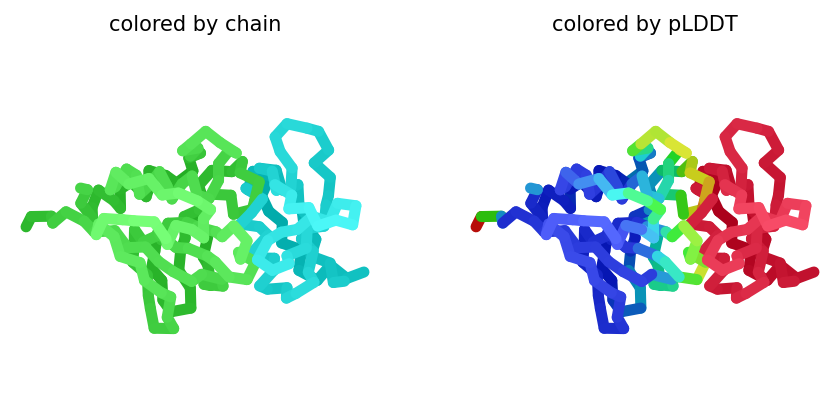

2025-09-10 12:53:19,188 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=63.7 pTM=0.641 ipTM=0.146
2025-09-10 12:53:34,948 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=64.1 pTM=0.642 ipTM=0.137 tol=3.37
2025-09-10 12:53:50,780 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=63.9 pTM=0.643 ipTM=0.145 tol=1.97
2025-09-10 12:54:06,400 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=63.7 pTM=0.638 ipTM=0.137 tol=2.54
2025-09-10 12:54:21,983 alphafold2_multimer_v3_model_2_seed_000 recycle=4 pLDDT=64.4 pTM=0.643 ipTM=0.147 tol=1.94
2025-09-10 12:54:37,563 alphafold2_multimer_v3_model_2_seed_000 recycle=5 pLDDT=62.9 pTM=0.638 ipTM=0.151 tol=1.02
2025-09-10 12:54:53,186 alphafold2_multimer_v3_model_2_seed_000 recycle=6 pLDDT=61.8 pTM=0.631 ipTM=0.139 tol=1.09
2025-09-10 12:55:08,826 alphafold2_multimer_v3_model_2_seed_000 recycle=7 pLDDT=60.7 pTM=0.623 ipTM=0.138 tol=1.03
2025-09-10 12:55:24,456 alphafold2_multimer_v3_model_2_seed_000 recycle=8 pLDDT=59.7 pTM=

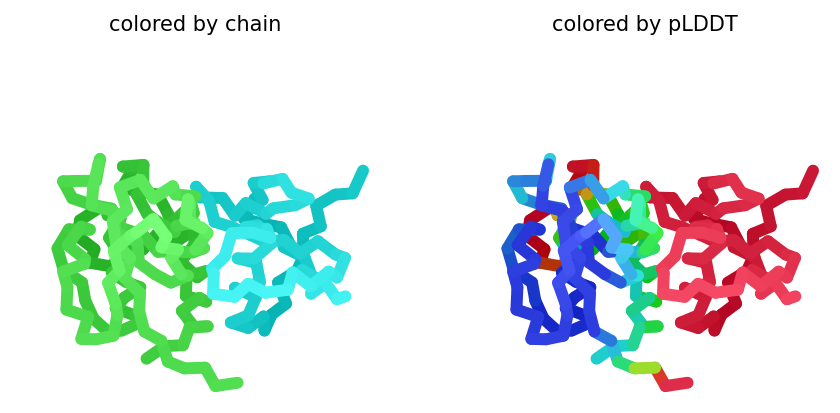

2025-09-10 12:56:43,065 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=64.8 pTM=0.649 ipTM=0.167
2025-09-10 12:56:58,687 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=67 pTM=0.651 ipTM=0.161 tol=3.29
2025-09-10 12:57:14,307 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=67.4 pTM=0.656 ipTM=0.171 tol=2.03
2025-09-10 12:57:29,927 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=67.9 pTM=0.657 ipTM=0.168 tol=1.46
2025-09-10 12:57:45,552 alphafold2_multimer_v3_model_3_seed_000 recycle=4 pLDDT=68.1 pTM=0.658 ipTM=0.177 tol=0.734
2025-09-10 12:58:01,184 alphafold2_multimer_v3_model_3_seed_000 recycle=5 pLDDT=68.8 pTM=0.658 ipTM=0.175 tol=1.02
2025-09-10 12:58:16,882 alphafold2_multimer_v3_model_3_seed_000 recycle=6 pLDDT=68.5 pTM=0.663 ipTM=0.195 tol=1.17
2025-09-10 12:58:32,529 alphafold2_multimer_v3_model_3_seed_000 recycle=7 pLDDT=68.5 pTM=0.654 ipTM=0.166 tol=1.18
2025-09-10 12:58:48,164 alphafold2_multimer_v3_model_3_seed_000 recycle=8 pLDDT=68.8 pTM=0

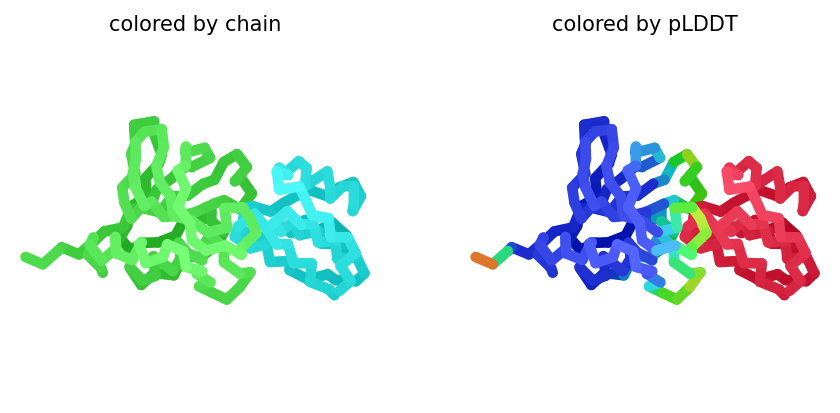

2025-09-10 13:00:06,785 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=63.4 pTM=0.653 ipTM=0.179
2025-09-10 13:00:22,435 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=64.9 pTM=0.652 ipTM=0.164 tol=2.99
2025-09-10 13:00:38,098 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=66.8 pTM=0.655 ipTM=0.175 tol=2.23
2025-09-10 13:00:53,744 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=67 pTM=0.658 ipTM=0.178 tol=1.01
2025-09-10 13:01:09,388 alphafold2_multimer_v3_model_4_seed_000 recycle=4 pLDDT=67.2 pTM=0.659 ipTM=0.177 tol=0.74
2025-09-10 13:01:25,031 alphafold2_multimer_v3_model_4_seed_000 recycle=5 pLDDT=67.8 pTM=0.66 ipTM=0.18 tol=1.2
2025-09-10 13:01:40,744 alphafold2_multimer_v3_model_4_seed_000 recycle=6 pLDDT=67.6 pTM=0.661 ipTM=0.197 tol=0.754
2025-09-10 13:01:56,385 alphafold2_multimer_v3_model_4_seed_000 recycle=7 pLDDT=67.7 pTM=0.659 ipTM=0.189 tol=1.13
2025-09-10 13:02:12,010 alphafold2_multimer_v3_model_4_seed_000 recycle=8 pLDDT=68.2 pTM=0.66

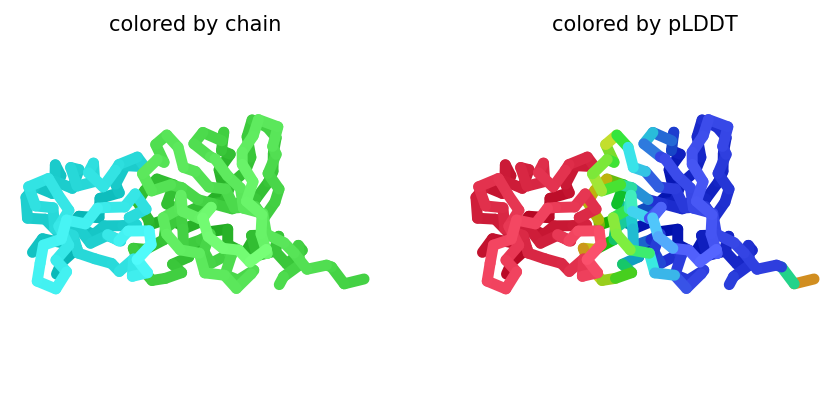

2025-09-10 13:03:30,476 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=64.2 pTM=0.645 ipTM=0.15
2025-09-10 13:03:46,114 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=67.1 pTM=0.649 ipTM=0.155 tol=1.61
2025-09-10 13:04:01,748 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=69.7 pTM=0.65 ipTM=0.151 tol=1.93
2025-09-10 13:04:17,376 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=69.4 pTM=0.645 ipTM=0.135 tol=1.63
2025-09-10 13:04:32,999 alphafold2_multimer_v3_model_5_seed_000 recycle=4 pLDDT=69.2 pTM=0.651 ipTM=0.152 tol=1.39
2025-09-10 13:04:48,645 alphafold2_multimer_v3_model_5_seed_000 recycle=5 pLDDT=69.9 pTM=0.652 ipTM=0.154 tol=1.74
2025-09-10 13:05:04,293 alphafold2_multimer_v3_model_5_seed_000 recycle=6 pLDDT=69.5 pTM=0.651 ipTM=0.152 tol=2.47
2025-09-10 13:05:19,959 alphafold2_multimer_v3_model_5_seed_000 recycle=7 pLDDT=69.9 pTM=0.646 ipTM=0.137 tol=1.8
2025-09-10 13:05:35,621 alphafold2_multimer_v3_model_5_seed_000 recycle=8 pLDDT=70.3 pTM=0.6

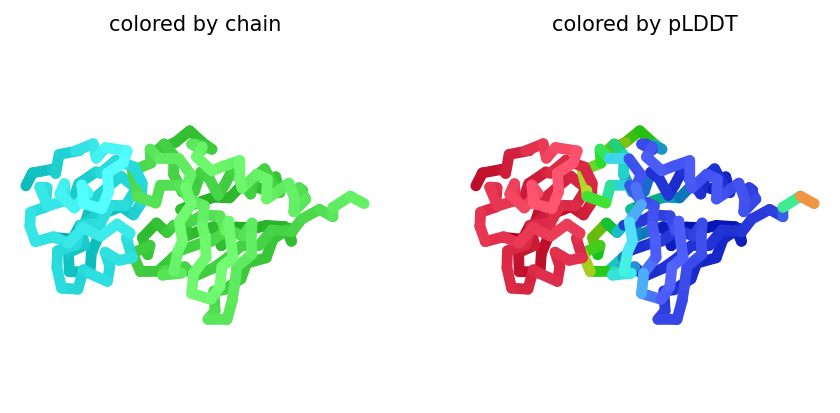

2025-09-10 13:06:54,207 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=63.3 pTM=0.626 ipTM=0.0994
2025-09-10 13:07:09,841 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=63.8 pTM=0.639 ipTM=0.126 tol=5.3
2025-09-10 13:07:25,510 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=64.8 pTM=0.643 ipTM=0.131 tol=1.31
2025-09-10 13:07:41,154 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=64.6 pTM=0.643 ipTM=0.139 tol=1.6
2025-09-10 13:07:56,826 alphafold2_multimer_v3_model_1_seed_001 recycle=4 pLDDT=64.8 pTM=0.64 ipTM=0.13 tol=1.72
2025-09-10 13:08:12,479 alphafold2_multimer_v3_model_1_seed_001 recycle=5 pLDDT=64.2 pTM=0.64 ipTM=0.134 tol=0.753
2025-09-10 13:08:28,147 alphafold2_multimer_v3_model_1_seed_001 recycle=6 pLDDT=64.2 pTM=0.643 ipTM=0.141 tol=1.12
2025-09-10 13:08:43,866 alphafold2_multimer_v3_model_1_seed_001 recycle=7 pLDDT=64.9 pTM=0.647 ipTM=0.153 tol=1.17
2025-09-10 13:08:59,505 alphafold2_multimer_v3_model_1_seed_001 recycle=8 pLDDT=64.2 pTM=0.6

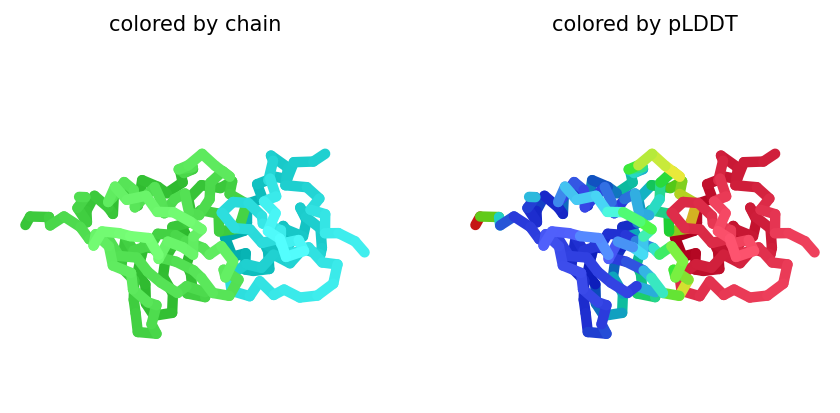

2025-09-10 13:10:18,050 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=63.8 pTM=0.635 ipTM=0.126
2025-09-10 13:10:33,693 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=64.6 pTM=0.646 ipTM=0.145 tol=1.96
2025-09-10 13:10:49,328 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=64.8 pTM=0.646 ipTM=0.147 tol=2.28
2025-09-10 13:11:04,981 alphafold2_multimer_v3_model_2_seed_001 recycle=3 pLDDT=64.5 pTM=0.64 ipTM=0.138 tol=1.82
2025-09-10 13:11:20,717 alphafold2_multimer_v3_model_2_seed_001 recycle=4 pLDDT=66 pTM=0.646 ipTM=0.148 tol=1.22
2025-09-10 13:11:36,366 alphafold2_multimer_v3_model_2_seed_001 recycle=5 pLDDT=65.3 pTM=0.637 ipTM=0.13 tol=1.28
2025-09-10 13:11:52,016 alphafold2_multimer_v3_model_2_seed_001 recycle=6 pLDDT=66.8 pTM=0.638 ipTM=0.137 tol=1.25
2025-09-10 13:12:07,749 alphafold2_multimer_v3_model_2_seed_001 recycle=7 pLDDT=67.9 pTM=0.644 ipTM=0.149 tol=1.55
2025-09-10 13:12:23,388 alphafold2_multimer_v3_model_2_seed_001 recycle=8 pLDDT=67.7 pTM=0.64

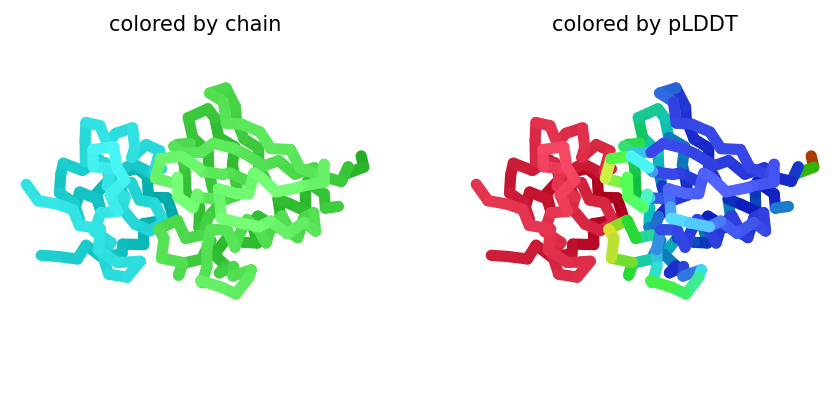

2025-09-10 13:13:41,775 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=65.2 pTM=0.65 ipTM=0.162
2025-09-10 13:13:57,471 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=66.6 pTM=0.657 ipTM=0.174 tol=1.99
2025-09-10 13:14:13,117 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=68.1 pTM=0.656 ipTM=0.164 tol=2.33
2025-09-10 13:14:28,757 alphafold2_multimer_v3_model_3_seed_001 recycle=3 pLDDT=68.2 pTM=0.659 ipTM=0.178 tol=1.86
2025-09-10 13:14:44,499 alphafold2_multimer_v3_model_3_seed_001 recycle=4 pLDDT=68.9 pTM=0.657 ipTM=0.177 tol=1.23
2025-09-10 13:15:00,151 alphafold2_multimer_v3_model_3_seed_001 recycle=5 pLDDT=68.3 pTM=0.652 ipTM=0.168 tol=1.27
2025-09-10 13:15:15,775 alphafold2_multimer_v3_model_3_seed_001 recycle=6 pLDDT=68.8 pTM=0.655 ipTM=0.169 tol=1.3
2025-09-10 13:15:31,443 alphafold2_multimer_v3_model_3_seed_001 recycle=7 pLDDT=69.2 pTM=0.66 ipTM=0.174 tol=1.14
2025-09-10 13:15:47,118 alphafold2_multimer_v3_model_3_seed_001 recycle=8 pLDDT=69.6 pTM=0.6

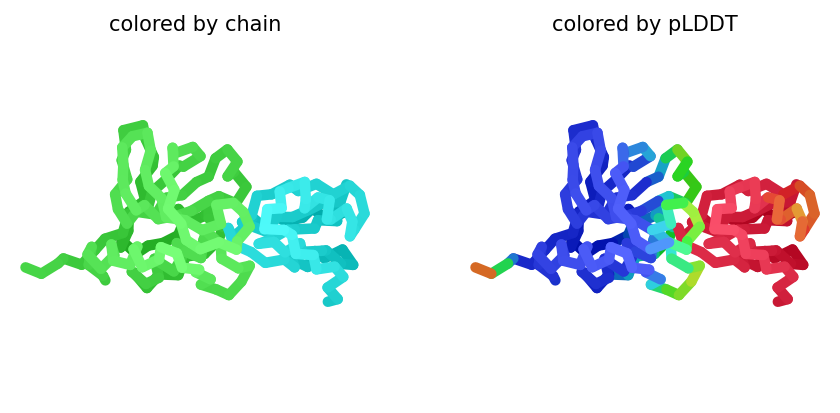

2025-09-10 13:17:05,693 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=63.7 pTM=0.648 ipTM=0.154
2025-09-10 13:17:21,419 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=65.4 pTM=0.649 ipTM=0.162 tol=2.6
2025-09-10 13:17:37,075 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=67.6 pTM=0.654 ipTM=0.174 tol=2.21
2025-09-10 13:17:52,708 alphafold2_multimer_v3_model_4_seed_001 recycle=3 pLDDT=68.8 pTM=0.657 ipTM=0.179 tol=2.74
2025-09-10 13:18:08,392 alphafold2_multimer_v3_model_4_seed_001 recycle=4 pLDDT=67.6 pTM=0.654 ipTM=0.167 tol=2.12
2025-09-10 13:18:24,032 alphafold2_multimer_v3_model_4_seed_001 recycle=5 pLDDT=67.5 pTM=0.655 ipTM=0.18 tol=1.84
2025-09-10 13:18:39,669 alphafold2_multimer_v3_model_4_seed_001 recycle=6 pLDDT=67.2 pTM=0.658 ipTM=0.181 tol=1.25
2025-09-10 13:18:55,315 alphafold2_multimer_v3_model_4_seed_001 recycle=7 pLDDT=67.8 pTM=0.659 ipTM=0.19 tol=0.543
2025-09-10 13:19:10,964 alphafold2_multimer_v3_model_4_seed_001 recycle=8 pLDDT=67.6 pTM=0.

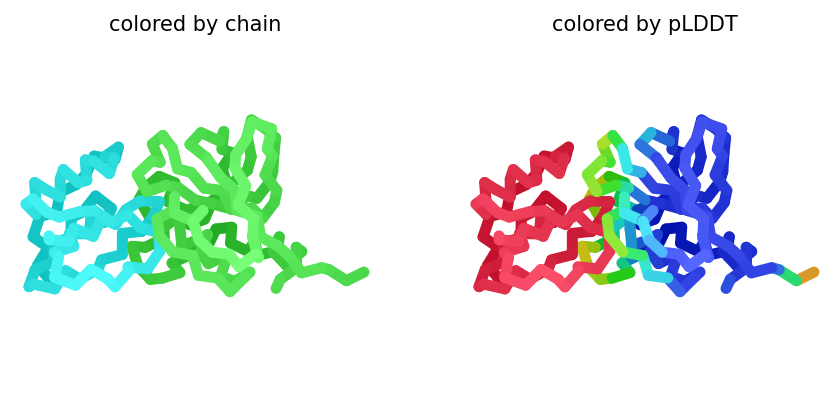

2025-09-10 13:20:29,534 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=65.1 pTM=0.647 ipTM=0.15
2025-09-10 13:20:45,296 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=65.1 pTM=0.648 ipTM=0.156 tol=3.63
2025-09-10 13:21:00,965 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=66.5 pTM=0.647 ipTM=0.145 tol=1.7
2025-09-10 13:21:16,594 alphafold2_multimer_v3_model_5_seed_001 recycle=3 pLDDT=67 pTM=0.652 ipTM=0.16 tol=3.36
2025-09-10 13:21:32,214 alphafold2_multimer_v3_model_5_seed_001 recycle=4 pLDDT=67.6 pTM=0.647 ipTM=0.147 tol=2.16
2025-09-10 13:21:47,864 alphafold2_multimer_v3_model_5_seed_001 recycle=5 pLDDT=67.9 pTM=0.648 ipTM=0.146 tol=2.04
2025-09-10 13:22:03,493 alphafold2_multimer_v3_model_5_seed_001 recycle=6 pLDDT=67.7 pTM=0.649 ipTM=0.15 tol=2.59
2025-09-10 13:22:19,121 alphafold2_multimer_v3_model_5_seed_001 recycle=7 pLDDT=68.4 pTM=0.654 ipTM=0.166 tol=2.43
2025-09-10 13:22:34,828 alphafold2_multimer_v3_model_5_seed_001 recycle=8 pLDDT=68 pTM=0.651 ip

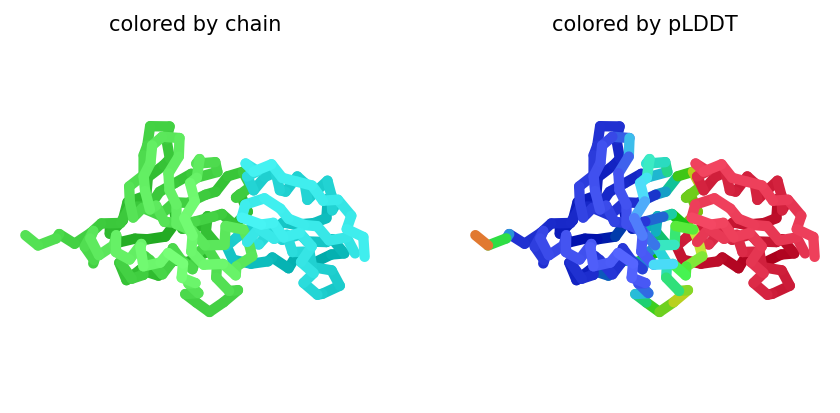

2025-09-10 13:23:53,414 alphafold2_multimer_v3_model_1_seed_002 recycle=0 pLDDT=63 pTM=0.629 ipTM=0.116
2025-09-10 13:24:09,067 alphafold2_multimer_v3_model_1_seed_002 recycle=1 pLDDT=62 pTM=0.631 ipTM=0.104 tol=5.9
2025-09-10 13:24:24,699 alphafold2_multimer_v3_model_1_seed_002 recycle=2 pLDDT=62.5 pTM=0.634 ipTM=0.109 tol=3.72
2025-09-10 13:24:40,339 alphafold2_multimer_v3_model_1_seed_002 recycle=3 pLDDT=62.7 pTM=0.635 ipTM=0.116 tol=2.88
2025-09-10 13:24:55,980 alphafold2_multimer_v3_model_1_seed_002 recycle=4 pLDDT=63 pTM=0.642 ipTM=0.136 tol=1.46
2025-09-10 13:25:11,665 alphafold2_multimer_v3_model_1_seed_002 recycle=5 pLDDT=63.4 pTM=0.64 ipTM=0.139 tol=1.33
2025-09-10 13:25:27,291 alphafold2_multimer_v3_model_1_seed_002 recycle=6 pLDDT=62.8 pTM=0.636 ipTM=0.128 tol=1.32
2025-09-10 13:25:42,912 alphafold2_multimer_v3_model_1_seed_002 recycle=7 pLDDT=63.1 pTM=0.64 ipTM=0.133 tol=1.53
2025-09-10 13:25:58,604 alphafold2_multimer_v3_model_1_seed_002 recycle=8 pLDDT=62.3 pTM=0.635 ipT

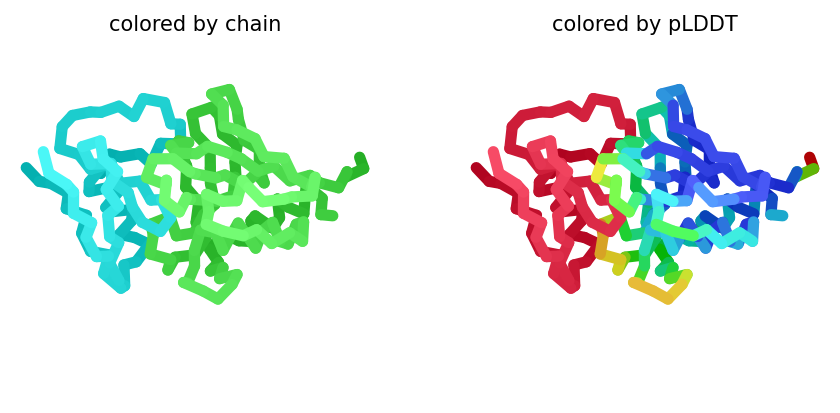

2025-09-10 13:27:17,019 alphafold2_multimer_v3_model_2_seed_002 recycle=0 pLDDT=62.9 pTM=0.632 ipTM=0.131
2025-09-10 13:27:32,665 alphafold2_multimer_v3_model_2_seed_002 recycle=1 pLDDT=63.9 pTM=0.637 ipTM=0.13 tol=3.14
2025-09-10 13:27:48,287 alphafold2_multimer_v3_model_2_seed_002 recycle=2 pLDDT=63.8 pTM=0.638 ipTM=0.131 tol=2
2025-09-10 13:28:03,915 alphafold2_multimer_v3_model_2_seed_002 recycle=3 pLDDT=63 pTM=0.635 ipTM=0.14 tol=1.25
2025-09-10 13:28:19,517 alphafold2_multimer_v3_model_2_seed_002 recycle=4 pLDDT=63.5 pTM=0.637 ipTM=0.142 tol=1.24
2025-09-10 13:28:35,205 alphafold2_multimer_v3_model_2_seed_002 recycle=5 pLDDT=64.1 pTM=0.633 ipTM=0.143 tol=1.02
2025-09-10 13:28:50,821 alphafold2_multimer_v3_model_2_seed_002 recycle=6 pLDDT=64.6 pTM=0.624 ipTM=0.13 tol=1.12
2025-09-10 13:29:06,414 alphafold2_multimer_v3_model_2_seed_002 recycle=7 pLDDT=65.1 pTM=0.625 ipTM=0.132 tol=1.07
2025-09-10 13:29:22,008 alphafold2_multimer_v3_model_2_seed_002 recycle=8 pLDDT=63.3 pTM=0.617 ip

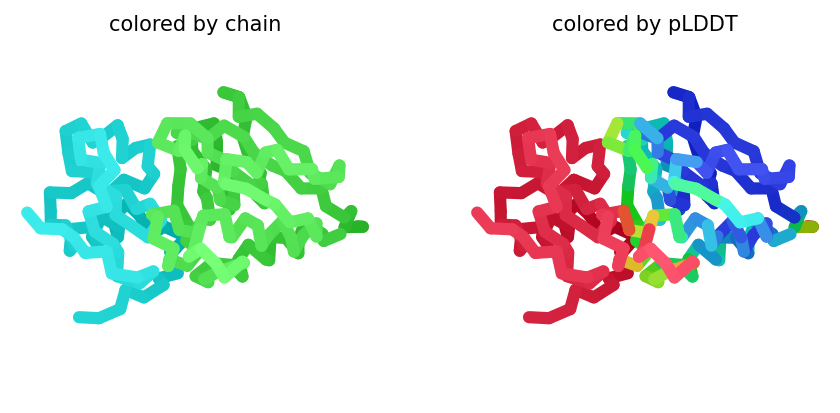

2025-09-10 13:30:40,348 alphafold2_multimer_v3_model_3_seed_002 recycle=0 pLDDT=66.5 pTM=0.656 ipTM=0.177
2025-09-10 13:30:55,982 alphafold2_multimer_v3_model_3_seed_002 recycle=1 pLDDT=68.9 pTM=0.658 ipTM=0.178 tol=3.06
2025-09-10 13:31:11,714 alphafold2_multimer_v3_model_3_seed_002 recycle=2 pLDDT=68.9 pTM=0.648 ipTM=0.157 tol=1.15
2025-09-10 13:31:27,357 alphafold2_multimer_v3_model_3_seed_002 recycle=3 pLDDT=69.1 pTM=0.648 ipTM=0.147 tol=1.7
2025-09-10 13:31:43,004 alphafold2_multimer_v3_model_3_seed_002 recycle=4 pLDDT=69 pTM=0.654 ipTM=0.172 tol=0.964
2025-09-10 13:31:58,729 alphafold2_multimer_v3_model_3_seed_002 recycle=5 pLDDT=69.1 pTM=0.651 ipTM=0.16 tol=1.58
2025-09-10 13:32:14,372 alphafold2_multimer_v3_model_3_seed_002 recycle=6 pLDDT=69.1 pTM=0.653 ipTM=0.162 tol=1.44
2025-09-10 13:32:30,039 alphafold2_multimer_v3_model_3_seed_002 recycle=7 pLDDT=69.2 pTM=0.653 ipTM=0.165 tol=1.42
2025-09-10 13:32:45,661 alphafold2_multimer_v3_model_3_seed_002 recycle=8 pLDDT=70.9 pTM=0.6

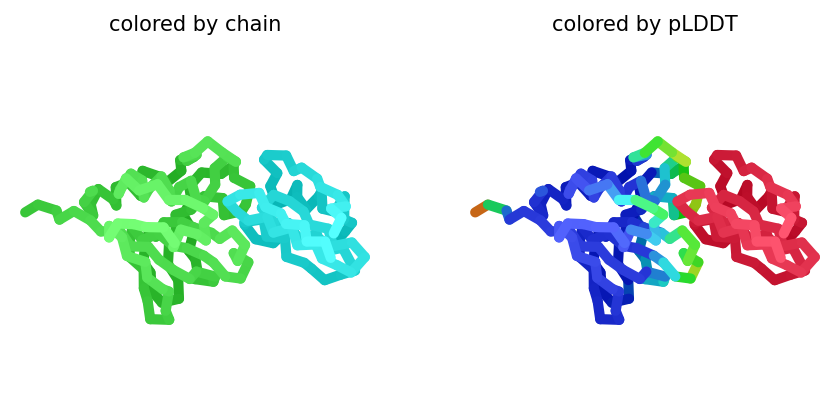

2025-09-10 13:34:04,317 alphafold2_multimer_v3_model_4_seed_002 recycle=0 pLDDT=62.8 pTM=0.651 ipTM=0.178
2025-09-10 13:34:19,957 alphafold2_multimer_v3_model_4_seed_002 recycle=1 pLDDT=65.2 pTM=0.656 ipTM=0.175 tol=3.79
2025-09-10 13:34:35,657 alphafold2_multimer_v3_model_4_seed_002 recycle=2 pLDDT=66.3 pTM=0.648 ipTM=0.157 tol=2.03
2025-09-10 13:34:51,277 alphafold2_multimer_v3_model_4_seed_002 recycle=3 pLDDT=67.6 pTM=0.656 ipTM=0.184 tol=1.98
2025-09-10 13:35:06,905 alphafold2_multimer_v3_model_4_seed_002 recycle=4 pLDDT=68.4 pTM=0.662 ipTM=0.191 tol=1.12
2025-09-10 13:35:22,532 alphafold2_multimer_v3_model_4_seed_002 recycle=5 pLDDT=68.7 pTM=0.66 ipTM=0.187 tol=1.33
2025-09-10 13:35:38,172 alphafold2_multimer_v3_model_4_seed_002 recycle=6 pLDDT=68.4 pTM=0.665 ipTM=0.2 tol=1.39
2025-09-10 13:35:53,811 alphafold2_multimer_v3_model_4_seed_002 recycle=7 pLDDT=68.9 pTM=0.666 ipTM=0.198 tol=0.686
2025-09-10 13:36:09,438 alphafold2_multimer_v3_model_4_seed_002 recycle=8 pLDDT=68.5 pTM=0.

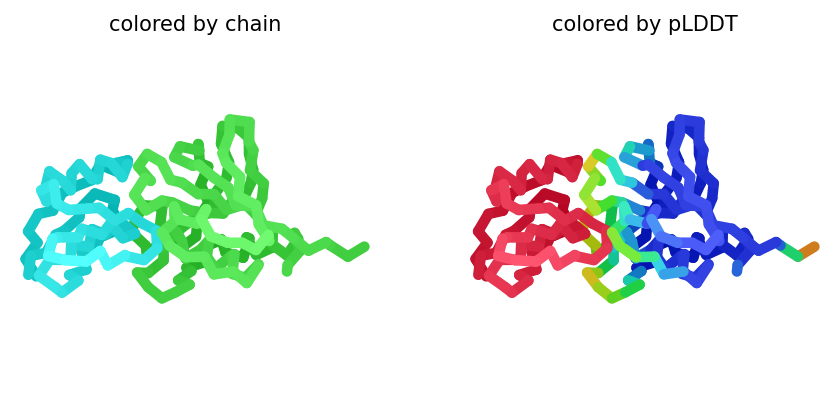

2025-09-10 13:37:28,173 alphafold2_multimer_v3_model_5_seed_002 recycle=0 pLDDT=63.8 pTM=0.644 ipTM=0.158
2025-09-10 13:37:43,794 alphafold2_multimer_v3_model_5_seed_002 recycle=1 pLDDT=67 pTM=0.657 ipTM=0.172 tol=3.08
2025-09-10 13:37:59,534 alphafold2_multimer_v3_model_5_seed_002 recycle=2 pLDDT=67.3 pTM=0.649 ipTM=0.15 tol=1.55
2025-09-10 13:38:15,175 alphafold2_multimer_v3_model_5_seed_002 recycle=3 pLDDT=67.5 pTM=0.651 ipTM=0.155 tol=1.77
2025-09-10 13:38:30,831 alphafold2_multimer_v3_model_5_seed_002 recycle=4 pLDDT=67.3 pTM=0.649 ipTM=0.156 tol=1.36
2025-09-10 13:38:46,484 alphafold2_multimer_v3_model_5_seed_002 recycle=5 pLDDT=68 pTM=0.65 ipTM=0.155 tol=0.838
2025-09-10 13:39:02,142 alphafold2_multimer_v3_model_5_seed_002 recycle=6 pLDDT=67.8 pTM=0.648 ipTM=0.151 tol=0.785
2025-09-10 13:39:17,789 alphafold2_multimer_v3_model_5_seed_002 recycle=7 pLDDT=67.6 pTM=0.649 ipTM=0.148 tol=1.2
2025-09-10 13:39:33,434 alphafold2_multimer_v3_model_5_seed_002 recycle=8 pLDDT=67.4 pTM=0.648

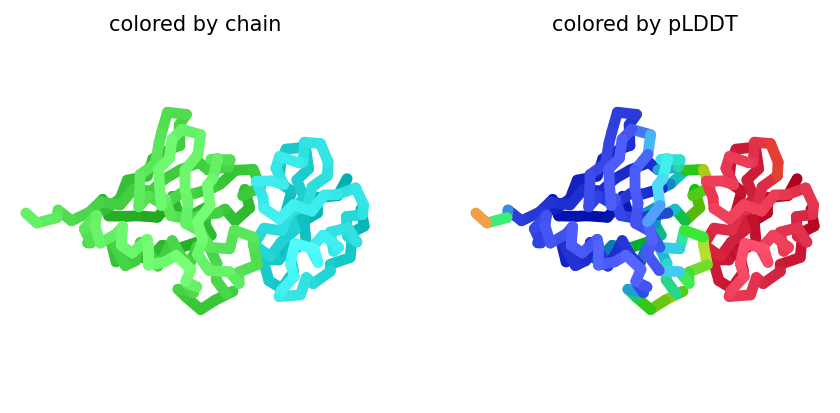

2025-09-10 13:40:52,181 alphafold2_multimer_v3_model_1_seed_003 recycle=0 pLDDT=63.1 pTM=0.635 ipTM=0.124
2025-09-10 13:41:07,801 alphafold2_multimer_v3_model_1_seed_003 recycle=1 pLDDT=62.2 pTM=0.626 ipTM=0.0929 tol=6.95
2025-09-10 13:41:23,509 alphafold2_multimer_v3_model_1_seed_003 recycle=2 pLDDT=62.4 pTM=0.634 ipTM=0.113 tol=2.87
2025-09-10 13:41:39,160 alphafold2_multimer_v3_model_1_seed_003 recycle=3 pLDDT=63.8 pTM=0.635 ipTM=0.119 tol=2.28
2025-09-10 13:41:54,785 alphafold2_multimer_v3_model_1_seed_003 recycle=4 pLDDT=63.1 pTM=0.635 ipTM=0.122 tol=1.15
2025-09-10 13:42:10,450 alphafold2_multimer_v3_model_1_seed_003 recycle=5 pLDDT=63.3 pTM=0.635 ipTM=0.125 tol=1.74
2025-09-10 13:42:26,089 alphafold2_multimer_v3_model_1_seed_003 recycle=6 pLDDT=63.3 pTM=0.631 ipTM=0.117 tol=0.756
2025-09-10 13:42:41,720 alphafold2_multimer_v3_model_1_seed_003 recycle=7 pLDDT=62.2 pTM=0.631 ipTM=0.12 tol=1.7
2025-09-10 13:42:57,346 alphafold2_multimer_v3_model_1_seed_003 recycle=8 pLDDT=63.5 pTM=

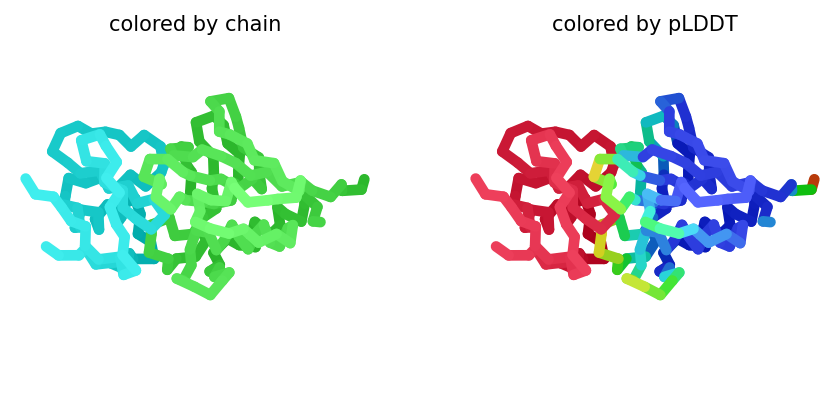

2025-09-10 13:44:15,901 alphafold2_multimer_v3_model_2_seed_003 recycle=0 pLDDT=63.5 pTM=0.637 ipTM=0.139
2025-09-10 13:44:31,534 alphafold2_multimer_v3_model_2_seed_003 recycle=1 pLDDT=64.8 pTM=0.643 ipTM=0.147 tol=4.8
2025-09-10 13:44:47,148 alphafold2_multimer_v3_model_2_seed_003 recycle=2 pLDDT=62.8 pTM=0.633 ipTM=0.143 tol=1.78
2025-09-10 13:45:02,795 alphafold2_multimer_v3_model_2_seed_003 recycle=3 pLDDT=61.2 pTM=0.622 ipTM=0.146 tol=1.09
2025-09-10 13:45:18,429 alphafold2_multimer_v3_model_2_seed_003 recycle=4 pLDDT=60.9 pTM=0.614 ipTM=0.145 tol=0.944
2025-09-10 13:45:34,069 alphafold2_multimer_v3_model_2_seed_003 recycle=5 pLDDT=61.3 pTM=0.619 ipTM=0.145 tol=3.04
2025-09-10 13:45:49,772 alphafold2_multimer_v3_model_2_seed_003 recycle=6 pLDDT=61.5 pTM=0.615 ipTM=0.15 tol=2.03
2025-09-10 13:46:05,418 alphafold2_multimer_v3_model_2_seed_003 recycle=7 pLDDT=62 pTM=0.627 ipTM=0.156 tol=1.67
2025-09-10 13:46:21,035 alphafold2_multimer_v3_model_2_seed_003 recycle=8 pLDDT=61 pTM=0.618

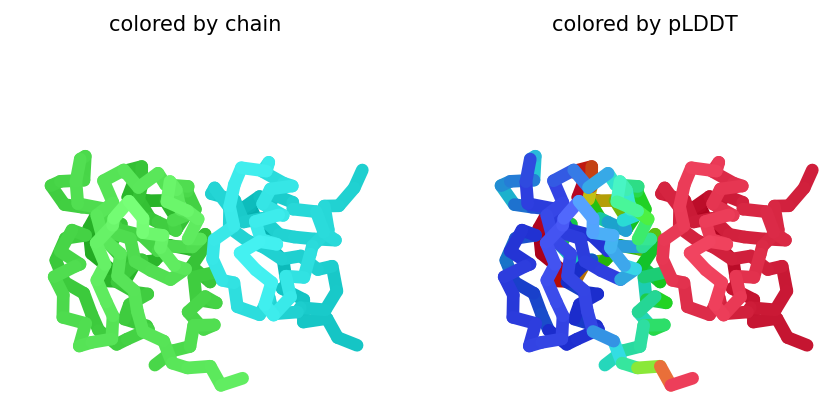

2025-09-10 13:47:39,449 alphafold2_multimer_v3_model_3_seed_003 recycle=0 pLDDT=66.8 pTM=0.658 ipTM=0.183
2025-09-10 13:47:55,077 alphafold2_multimer_v3_model_3_seed_003 recycle=1 pLDDT=67.9 pTM=0.656 ipTM=0.17 tol=2.6
2025-09-10 13:48:10,679 alphafold2_multimer_v3_model_3_seed_003 recycle=2 pLDDT=67.5 pTM=0.653 ipTM=0.161 tol=1.77
2025-09-10 13:48:26,356 alphafold2_multimer_v3_model_3_seed_003 recycle=3 pLDDT=68.3 pTM=0.653 ipTM=0.168 tol=1.16
2025-09-10 13:48:41,960 alphafold2_multimer_v3_model_3_seed_003 recycle=4 pLDDT=68.8 pTM=0.651 ipTM=0.155 tol=1.37
2025-09-10 13:48:57,573 alphafold2_multimer_v3_model_3_seed_003 recycle=5 pLDDT=69.7 pTM=0.651 ipTM=0.162 tol=1.4
2025-09-10 13:49:13,268 alphafold2_multimer_v3_model_3_seed_003 recycle=6 pLDDT=69.4 pTM=0.653 ipTM=0.164 tol=0.834
2025-09-10 13:49:28,875 alphafold2_multimer_v3_model_3_seed_003 recycle=7 pLDDT=69.4 pTM=0.657 ipTM=0.173 tol=0.907
2025-09-10 13:49:44,490 alphafold2_multimer_v3_model_3_seed_003 recycle=8 pLDDT=70.2 pTM=0

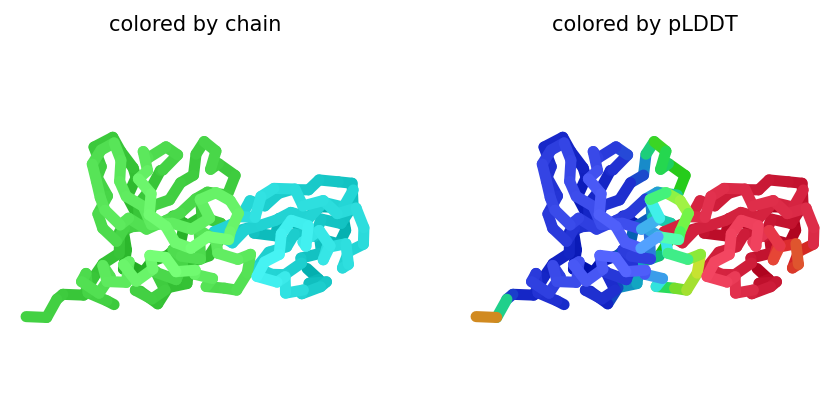

2025-09-10 13:51:02,907 alphafold2_multimer_v3_model_4_seed_003 recycle=0 pLDDT=63.6 pTM=0.655 ipTM=0.171
2025-09-10 13:51:18,560 alphafold2_multimer_v3_model_4_seed_003 recycle=1 pLDDT=65.8 pTM=0.658 ipTM=0.178 tol=2.5
2025-09-10 13:51:34,198 alphafold2_multimer_v3_model_4_seed_003 recycle=2 pLDDT=66.8 pTM=0.656 ipTM=0.172 tol=2.03
2025-09-10 13:51:49,822 alphafold2_multimer_v3_model_4_seed_003 recycle=3 pLDDT=66.9 pTM=0.657 ipTM=0.177 tol=1.61
2025-09-10 13:52:05,456 alphafold2_multimer_v3_model_4_seed_003 recycle=4 pLDDT=67.9 pTM=0.661 ipTM=0.192 tol=1.32
2025-09-10 13:52:21,096 alphafold2_multimer_v3_model_4_seed_003 recycle=5 pLDDT=68.4 pTM=0.665 ipTM=0.198 tol=1.79
2025-09-10 13:52:36,719 alphafold2_multimer_v3_model_4_seed_003 recycle=6 pLDDT=68.6 pTM=0.663 ipTM=0.2 tol=0.686
2025-09-10 13:52:52,342 alphafold2_multimer_v3_model_4_seed_003 recycle=7 pLDDT=68.4 pTM=0.667 ipTM=0.2 tol=0.936
2025-09-10 13:53:07,985 alphafold2_multimer_v3_model_4_seed_003 recycle=8 pLDDT=68.8 pTM=0.6

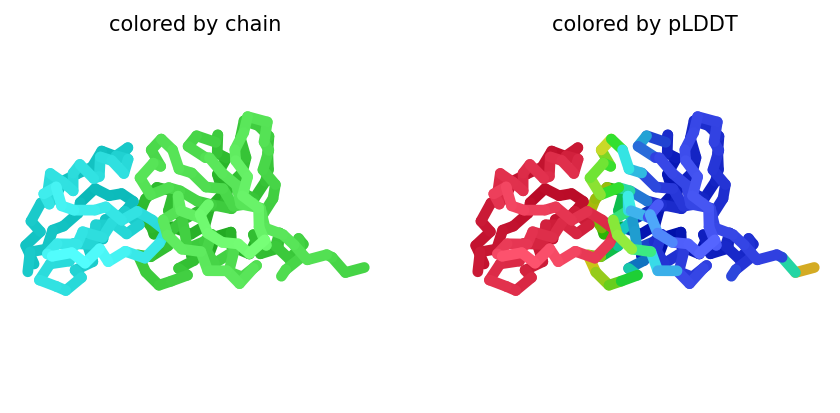

2025-09-10 13:54:26,541 alphafold2_multimer_v3_model_5_seed_003 recycle=0 pLDDT=65.1 pTM=0.65 ipTM=0.17
2025-09-10 13:54:42,212 alphafold2_multimer_v3_model_5_seed_003 recycle=1 pLDDT=68.5 pTM=0.653 ipTM=0.164 tol=2.08
2025-09-10 13:54:57,868 alphafold2_multimer_v3_model_5_seed_003 recycle=2 pLDDT=69.9 pTM=0.649 ipTM=0.148 tol=1.45
2025-09-10 13:55:13,512 alphafold2_multimer_v3_model_5_seed_003 recycle=3 pLDDT=69.9 pTM=0.646 ipTM=0.14 tol=0.855
2025-09-10 13:55:29,164 alphafold2_multimer_v3_model_5_seed_003 recycle=4 pLDDT=70.9 pTM=0.648 ipTM=0.14 tol=1.06
2025-09-10 13:55:44,812 alphafold2_multimer_v3_model_5_seed_003 recycle=5 pLDDT=70.6 pTM=0.648 ipTM=0.144 tol=0.825
2025-09-10 13:56:00,464 alphafold2_multimer_v3_model_5_seed_003 recycle=6 pLDDT=71.6 pTM=0.656 ipTM=0.172 tol=1.46
2025-09-10 13:56:16,119 alphafold2_multimer_v3_model_5_seed_003 recycle=7 pLDDT=70.4 pTM=0.645 ipTM=0.138 tol=3.46
2025-09-10 13:56:31,742 alphafold2_multimer_v3_model_5_seed_003 recycle=8 pLDDT=70.6 pTM=0.

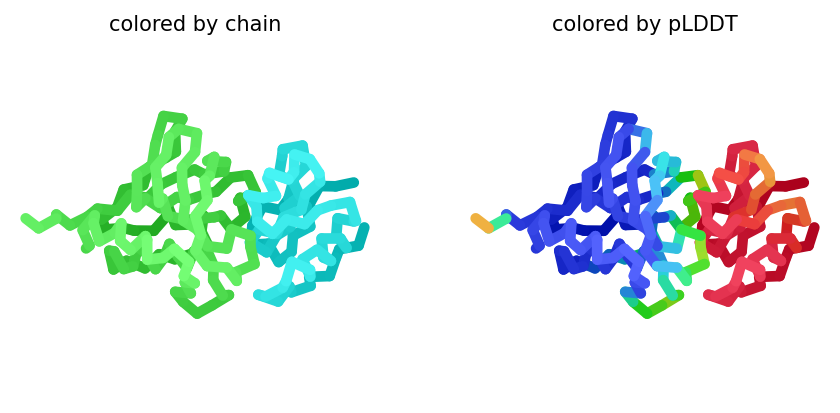

2025-09-10 13:57:50,114 alphafold2_multimer_v3_model_1_seed_004 recycle=0 pLDDT=63.6 pTM=0.624 ipTM=0.0987
2025-09-10 13:58:05,843 alphafold2_multimer_v3_model_1_seed_004 recycle=1 pLDDT=62.9 pTM=0.63 ipTM=0.107 tol=7.18
2025-09-10 13:58:21,474 alphafold2_multimer_v3_model_1_seed_004 recycle=2 pLDDT=62.8 pTM=0.63 ipTM=0.101 tol=3.54
2025-09-10 13:58:37,095 alphafold2_multimer_v3_model_1_seed_004 recycle=3 pLDDT=63.4 pTM=0.636 ipTM=0.127 tol=2.59
2025-09-10 13:58:52,704 alphafold2_multimer_v3_model_1_seed_004 recycle=4 pLDDT=64.1 pTM=0.638 ipTM=0.127 tol=1.62
2025-09-10 13:59:08,339 alphafold2_multimer_v3_model_1_seed_004 recycle=5 pLDDT=64.2 pTM=0.641 ipTM=0.138 tol=0.861
2025-09-10 13:59:23,983 alphafold2_multimer_v3_model_1_seed_004 recycle=6 pLDDT=63.8 pTM=0.635 ipTM=0.127 tol=1.38
2025-09-10 13:59:39,606 alphafold2_multimer_v3_model_1_seed_004 recycle=7 pLDDT=64.5 pTM=0.64 ipTM=0.142 tol=1.51
2025-09-10 13:59:55,221 alphafold2_multimer_v3_model_1_seed_004 recycle=8 pLDDT=64.5 pTM=0

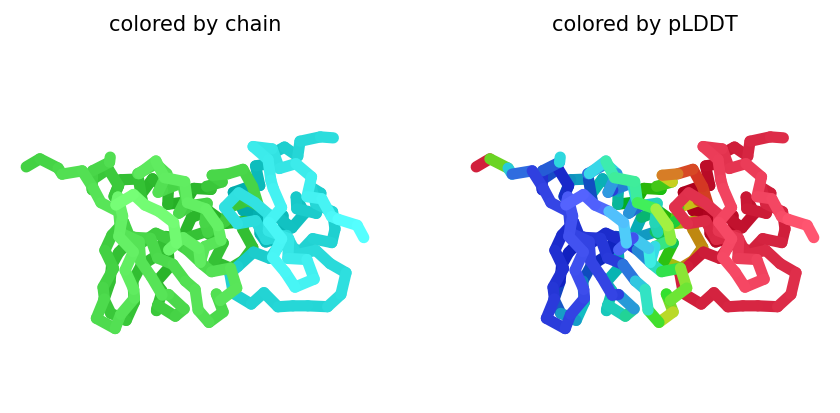

2025-09-10 14:01:13,697 alphafold2_multimer_v3_model_2_seed_004 recycle=0 pLDDT=63.6 pTM=0.634 ipTM=0.128
2025-09-10 14:01:29,414 alphafold2_multimer_v3_model_2_seed_004 recycle=1 pLDDT=63.8 pTM=0.639 ipTM=0.131 tol=2.77
2025-09-10 14:01:45,059 alphafold2_multimer_v3_model_2_seed_004 recycle=2 pLDDT=64 pTM=0.643 ipTM=0.149 tol=1.46
2025-09-10 14:02:00,685 alphafold2_multimer_v3_model_2_seed_004 recycle=3 pLDDT=62.5 pTM=0.634 ipTM=0.141 tol=1.6
2025-09-10 14:02:16,336 alphafold2_multimer_v3_model_2_seed_004 recycle=4 pLDDT=62.2 pTM=0.637 ipTM=0.137 tol=1.26
2025-09-10 14:02:31,961 alphafold2_multimer_v3_model_2_seed_004 recycle=5 pLDDT=61.8 pTM=0.633 ipTM=0.144 tol=1.39
2025-09-10 14:02:47,604 alphafold2_multimer_v3_model_2_seed_004 recycle=6 pLDDT=60.4 pTM=0.624 ipTM=0.147 tol=1
2025-09-10 14:03:03,225 alphafold2_multimer_v3_model_2_seed_004 recycle=7 pLDDT=59.2 pTM=0.614 ipTM=0.145 tol=0.869
2025-09-10 14:03:18,907 alphafold2_multimer_v3_model_2_seed_004 recycle=8 pLDDT=59.9 pTM=0.618

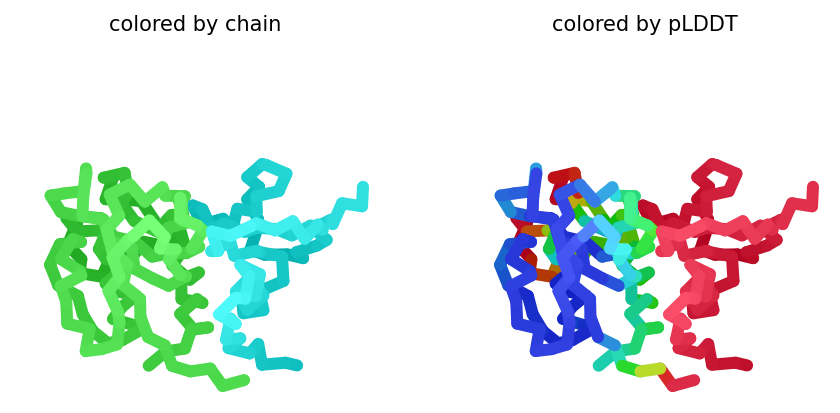

2025-09-10 14:04:37,336 alphafold2_multimer_v3_model_3_seed_004 recycle=0 pLDDT=67 pTM=0.647 ipTM=0.16
2025-09-10 14:04:52,964 alphafold2_multimer_v3_model_3_seed_004 recycle=1 pLDDT=68.2 pTM=0.649 ipTM=0.158 tol=2.75
2025-09-10 14:05:08,608 alphafold2_multimer_v3_model_3_seed_004 recycle=2 pLDDT=68.3 pTM=0.657 ipTM=0.173 tol=3.43
2025-09-10 14:05:24,242 alphafold2_multimer_v3_model_3_seed_004 recycle=3 pLDDT=68.8 pTM=0.656 ipTM=0.173 tol=1.36
2025-09-10 14:05:39,879 alphafold2_multimer_v3_model_3_seed_004 recycle=4 pLDDT=69 pTM=0.654 ipTM=0.162 tol=1.05
2025-09-10 14:05:55,530 alphafold2_multimer_v3_model_3_seed_004 recycle=5 pLDDT=69.6 pTM=0.656 ipTM=0.175 tol=1.33
2025-09-10 14:06:11,198 alphafold2_multimer_v3_model_3_seed_004 recycle=6 pLDDT=69.1 pTM=0.658 ipTM=0.172 tol=1.24
2025-09-10 14:06:26,837 alphafold2_multimer_v3_model_3_seed_004 recycle=7 pLDDT=69.9 pTM=0.662 ipTM=0.183 tol=1.36
2025-09-10 14:06:42,473 alphafold2_multimer_v3_model_3_seed_004 recycle=8 pLDDT=69.4 pTM=0.657

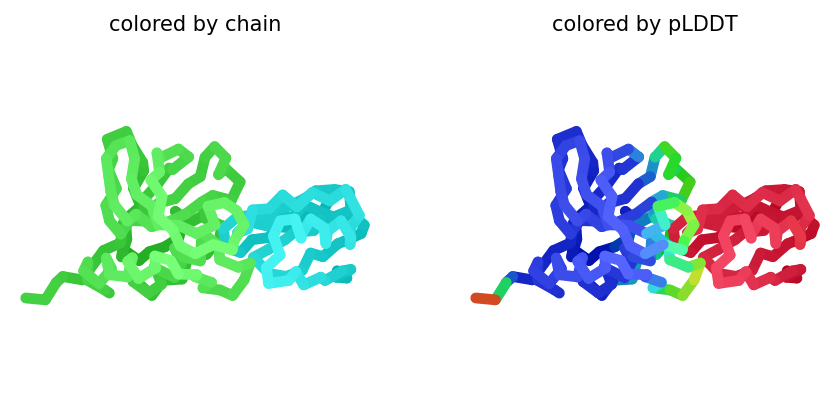

2025-09-10 14:08:01,328 alphafold2_multimer_v3_model_4_seed_004 recycle=0 pLDDT=64.7 pTM=0.646 ipTM=0.155
2025-09-10 14:08:16,959 alphafold2_multimer_v3_model_4_seed_004 recycle=1 pLDDT=67.2 pTM=0.649 ipTM=0.165 tol=2.41
2025-09-10 14:08:32,534 alphafold2_multimer_v3_model_4_seed_004 recycle=2 pLDDT=68.3 pTM=0.666 ipTM=0.202 tol=1.47
2025-09-10 14:08:48,133 alphafold2_multimer_v3_model_4_seed_004 recycle=3 pLDDT=67.8 pTM=0.663 ipTM=0.194 tol=0.714
2025-09-10 14:09:03,802 alphafold2_multimer_v3_model_4_seed_004 recycle=4 pLDDT=67.9 pTM=0.663 ipTM=0.196 tol=1.36
2025-09-10 14:09:19,486 alphafold2_multimer_v3_model_4_seed_004 recycle=5 pLDDT=68.2 pTM=0.662 ipTM=0.19 tol=1.01
2025-09-10 14:09:35,161 alphafold2_multimer_v3_model_4_seed_004 recycle=6 pLDDT=68.2 pTM=0.667 ipTM=0.207 tol=0.96
2025-09-10 14:09:50,884 alphafold2_multimer_v3_model_4_seed_004 recycle=7 pLDDT=68.9 pTM=0.672 ipTM=0.215 tol=0.851
2025-09-10 14:10:06,496 alphafold2_multimer_v3_model_4_seed_004 recycle=8 pLDDT=68.6 pTM

In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
